In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
import shutil
import string
import pickle
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from wordcloud import WordCloud
from tensorflow.keras import layers
from tensorflow.keras import losses


nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
STOP_WORDS = set(stopwords.words('english'))

RANDOM_STATE = 42

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Загрузка и изучение данных

In [ ]:
# загружаем файл с обучающими данными
!gdown 1aL8SitGy6m7GJaR_I7TfNikHTM45Va4F
train_data = pd.read_csv('imdb_train.csv')
train_data.head(10)

Downloading...
From: https://drive.google.com/uc?id=1aL8SitGy6m7GJaR_I7TfNikHTM45Va4F
To: /content/imdb_train.csv
100% 33.5M/33.5M [00:00<00:00, 53.8MB/s]


,id,review,rating,positive
0,4932,"Silent Night, Deadly Night 5 is the very last ...",4,0
1,9115,The idea ia a very short film with a lot of in...,10,1
2,7452,"For me, this movie just seemed to fall on its ...",4,0
3,11026,Was this based on a comic-book? A video-game? ...,7,1
4,11367,Caution: May contain spoilers...<br /><br />I'...,10,1
5,5490,"When I was a kid we always used to be babysat,...",1,0
6,3975,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,3,0
7,10369,"""A Cry in the Dark"" is a masterful piece of ci...",8,1
8,1799,"Skippy from ""Family Ties"" plays Eddie, a wussy...",3,0
9,7361,Mr Perlman gives a standout performance (as us...,3,0


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        25000 non-null  int64 
 1   review    25000 non-null  object
 2   rating    25000 non-null  int64 
 3   positive  25000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 781.4+ KB


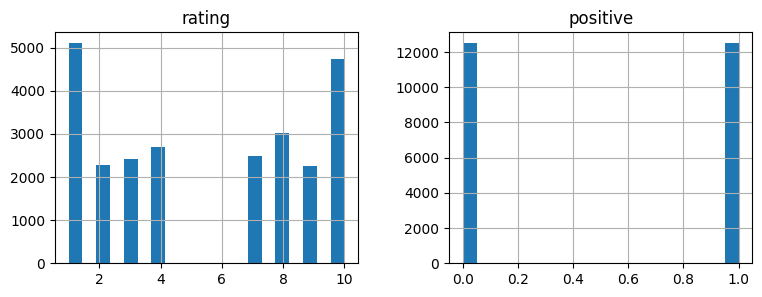

In [ ]:
train_data[['rating', 'positive']].hist(bins=20, figsize=(9,3))
plt.show()

In [ ]:
train_data['positive'].value_counts()

0    12500
1    12500
Name: positive, dtype: int64

In [ ]:
train_data['rating'].value_counts()

1     5100
10    4732
8     3009
4     2696
7     2496
3     2420
2     2284
9     2263
Name: rating, dtype: int64

In [ ]:
# загружаем файл с тестовыми данными
!gdown 1SWsJTW2Veq3CeEc6S4fZzNMSYsgxF7Iz
test_data = pd.read_csv('imdb_test.csv')
test_data.head(10)

Downloading...
From: https://drive.google.com/uc?id=1SWsJTW2Veq3CeEc6S4fZzNMSYsgxF7Iz
To: /content/imdb_test.csv
100% 32.7M/32.7M [00:00<00:00, 41.9MB/s]


,id,review,rating,positive
0,4932,"I hate guns and have never murdered anyone, bu...",3,0
1,9115,If you are like me and you bought the new Tena...,10,1
2,7452,"I have seen this movie several times, it sure ...",1,0
3,11026,There are many things to admire about this fil...,9,1
4,11367,"It was so very long ago (1960), but I have nev...",10,1
5,5490,This movie treads on very familiar ground -- t...,4,0
6,3975,"This film is a mediocre, low-budget flick. I'v...",4,0
7,10369,"As most other reviewers seem to agree, this ad...",9,1
8,1799,"The movie 'Heart of Darkness', based on the 18...",4,0
9,7361,What starts out as a passable movie degenerate...,1,0


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        25000 non-null  int64 
 1   review    25000 non-null  object
 2   rating    25000 non-null  int64 
 3   positive  25000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 781.4+ KB


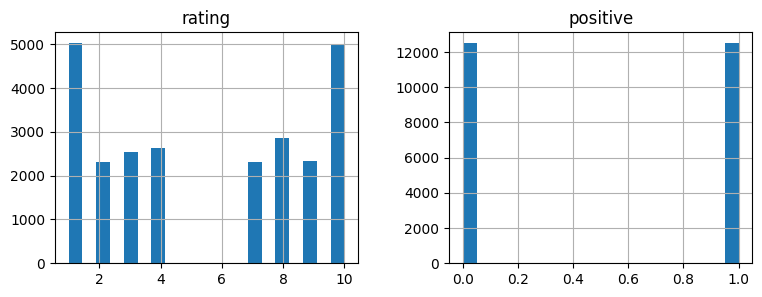

In [ ]:
test_data[['rating', 'positive']].hist(bins=20, figsize=(9,3))
plt.show()

In [ ]:
test_data['positive'].value_counts()

0    12500
1    12500
Name: positive, dtype: int64

In [ ]:
test_data['rating'].value_counts()

1     5022
10    4999
8     2850
4     2635
3     2541
9     2344
7     2307
2     2302
Name: rating, dtype: int64

**Выводы:**
1. Обучающая и тестовая выборки содержат по 25 тыс. записей с отзывами о фильмах, оценками (1-4 и 7-10) и статусами (1 - позитивный, 0 - негативный).
2. Пропусков в данных не обнаружено.
3. Классы статуса сбалансированы 1:1 в обеих выборках (по 12,5 тыс.).
4. Классы оценок в обучающей и  тестовой выборках имеют похожее распределение: самые популярные оценки - 1 и 10 (по ~5 тыс.); остальные оценки встречаются реже, но распределены по классам достаточно равномерно (от ~2 до 3 тыс.).

# Обработка текста

Очистим текст от лишних символов и стоп-слов, а также проведем лемматизацию с помощью WordNetLemmatizer:

In [ ]:
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text


def strip_all_entities(text):
    text = text.replace('<br />', ' ').replace('\r', '').replace('\n', ' ').lower() #remove <br />, \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = [word for word in text.split() if word not in STOP_WORDS]
    text = ' '.join(text)
    return text


def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
   # return ' '.join([lm.lemmatize(words) for words in tokenized])
    return ' '.join([lm.lemmatize(words, get_wordnet_pos(words)) for words in tokenized])


def deep_clean(text):
    text = decontract(text)
    text = strip_all_entities(text)
    text = remove_mult_spaces(text)
    text = lemmatize(text)
    return text

In [ ]:
%%time

train_data['text_clean'] = train_data['review'].apply(deep_clean)

CPU times: user 7min 53s, sys: 24.8 s, total: 8min 18s
Wall time: 8min 33s


In [ ]:
train_data.head()

,id,review,rating,positive,text_clean
0,4932,"Silent Night, Deadly Night 5 is the very last ...",4,0,silent night deadly night 5 last series like p...
1,9115,The idea ia a very short film with a lot of in...,10,1,idea ia short film lot information interest en...
2,7452,"For me, this movie just seemed to fall on its ...",4,0,movie seem fall face main problem cast glover ...
3,11026,Was this based on a comic-book? A video-game? ...,7,1,base comic book video game draw 3 year old not...
4,11367,Caution: May contain spoilers...<br /><br />I'...,10,1,caution may contain spoiler see movie 3 time l...


In [ ]:
%%time

test_data['text_clean'] = test_data['review'].apply(deep_clean)

CPU times: user 7min 37s, sys: 23.6 s, total: 8min 1s
Wall time: 8min 5s


In [ ]:
test_data.head()

,id,review,rating,positive,text_clean
0,4932,"I hate guns and have never murdered anyone, bu...",3,0,hate gun never murder anyone even half event t...
1,9115,If you are like me and you bought the new Tena...,10,1,like bought new tenacious album day come go fi...
2,7452,"I have seen this movie several times, it sure ...",1,0,see movie several time sure one cheapest actio...
3,11026,There are many things to admire about this fil...,9,1,many thing admire film thing get others part e...
4,11367,"It was so very long ago (1960), but I have nev...",10,1,long ago 1960 never forgotten series often wis...


In [ ]:
# проверка на дубликаты
train_data['text_clean'].duplicated().sum()

100

In [ ]:
# вывод дубликатов
train_data[train_data['text_clean'].duplicated(keep=False)].sort_values(by='text_clean').head(10)

,id,review,rating,positive,text_clean
53,2715,The 1960's were a time of change and awakening...,3,0,1960 time change awaken people social upheaval...
10529,5582,The 1960's were a time of change and awakening...,3,0,1960 time change awaken people social upheaval...
2723,7871,"In 1993, ""the visitors"" was an enormous hit in...",2,0,1993 visitor enormous hit france sequence inev...
9609,4985,"In 1993, ""the visitors"" was an enormous hit in...",2,0,1993 visitor enormous hit france sequence inev...
860,2714,The 60s (1999) D: Mark Piznarski. Josh Hamilto...,4,0,60 1999 mark piznarski josh hamilton julia sti...
6972,5581,The 60s (1999) D: Mark Piznarski. Josh Hamilto...,4,0,60 1999 mark piznarski josh hamilton julia sti...
16366,5579,"The '60s is an occasionally entertaining film,...",2,0,60 occasionally entertain film entertainment l...
11547,2712,"The '60s is an occasionally entertaining film,...",2,0,60 occasionally entertain film entertainment l...
19390,12318,"I absolutely hate this programme, what kind of...",1,0,absolutely hate programme kind people sit watc...
18444,7345,"I absolutely hate this programme, what kind of...",1,0,absolutely hate programme kind people sit watc...


In [ ]:
# удаление дубликатов
train_data = train_data.drop_duplicates("text_clean")

In [ ]:
#train_data.to_csv('train_data_clean.csv')

In [ ]:
#test_data.to_csv('test_data_clean.csv')

Выведем облака слов для негативных и позитивных отзывов:

In [ ]:
def word_cloud(text, title):
    pos_words = " ".join(text)
    pos_wordcloud =  WordCloud(width=800, height=500, collocations=False, stopwords=STOP_WORDS).generate(pos_words)

    plt.figure(figsize=(8, 8), facecolor = None)
    plt.imshow(pos_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title('Most frequently used words in {} reviews'.format(title), fontsize=14)
    plt.show()

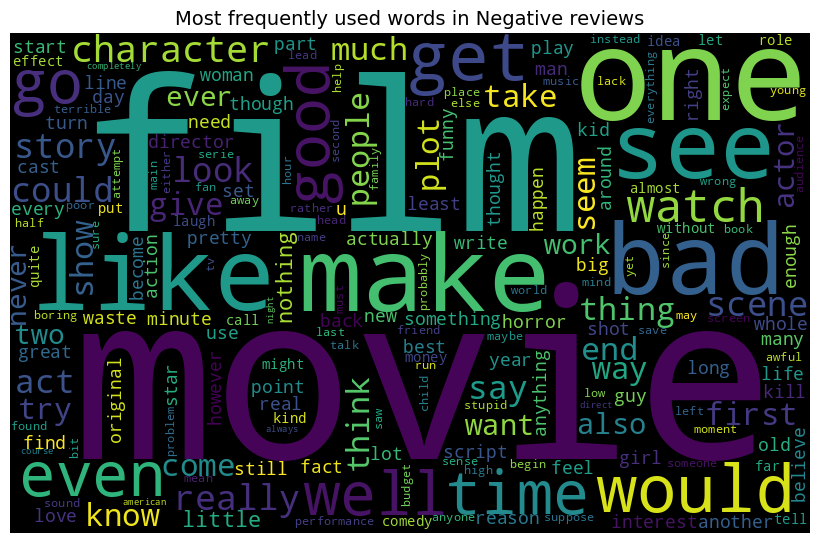

In [ ]:
word_cloud(train_data.query('positive==0')['text_clean'], 'Negative')

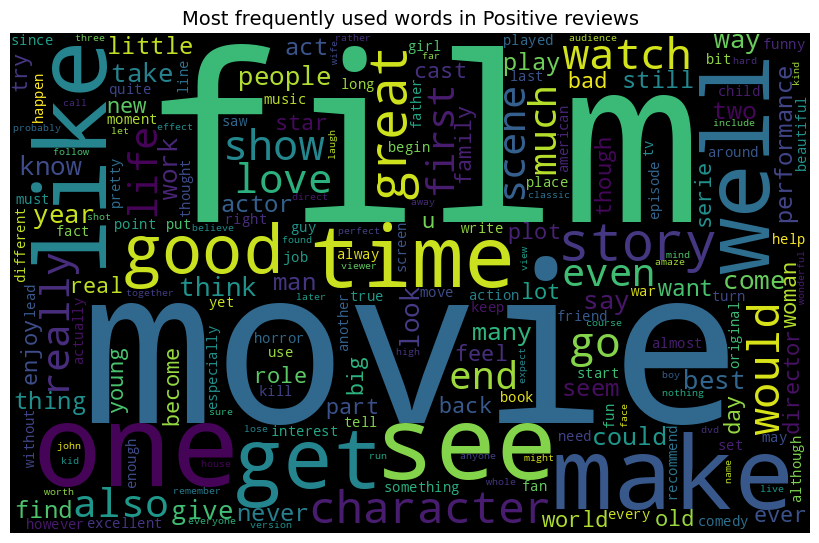

In [ ]:
word_cloud(train_data.query('positive==1')['text_clean'], 'Positive')

Наиболее популярные слова во многом совпадают (film, movie, one, see, make, like и др.), но при этом есть и заметные отличия: например, в негативных отзывах намного чаще встречается слово bad, а в позитивных слово love.

In [3]:
'''
# загрузка уже предобработанного текста
!gdown 1A9w5gD0-b6F-vKF-Lbis9mUwebQ9sW7E
train_data = pd.read_csv('train_data_clean.csv')
'''

Downloading...
From: https://drive.google.com/uc?id=1A9w5gD0-b6F-vKF-Lbis9mUwebQ9sW7E
To: /content/train_data_clean.csv
100% 53.3M/53.3M [00:00<00:00, 68.9MB/s]


In [4]:
'''
# загрузка уже предобработанного текста
!gdown 1OaeIXn6ZK2KqaWPMRTXVRqWim9gpfcoI
test_data = pd.read_csv('test_data_clean.csv')
'''

Downloading...
From: https://drive.google.com/uc?id=1OaeIXn6ZK2KqaWPMRTXVRqWim9gpfcoI
To: /content/test_data_clean.csv
100% 52.2M/52.2M [00:01<00:00, 52.1MB/s]


# Предсказание статуса (positive / negative)

## Классические ML-модели

Выбор лучшей модели и подбор параметров будем проводить на кросс-валидации с помощью RandomizedSearchCV.

Перед подачей текста в модель будем проводить его векторизацию с помощью TfidfVectorizer.

Так как классы целевого признака сбалансированы, то качество модели можно оценивать метрикой `accuracy` (доля верно угаданных ответов).

In [ ]:
# таблица для записи результатов
columns = ['model',  'accuracy', 'roc_auc', 'recall', 'precision', 'params']
cv_results = pd.DataFrame(columns=columns)

In [ ]:
def ml_processing(model_name, model, param_grid, features_train, target_train, cv_results):

    try:
        text_columns = features_train.select_dtypes(include='object').columns.to_list()
        col_transformer = make_column_transformer(
            (
                TfidfVectorizer(stop_words=list(STOP_WORDS)),
                'text_clean'
            ),
            remainder='passthrough'
        )
        pipline = make_pipeline(col_transformer, model)


        rs_model = RandomizedSearchCV(pipline,
                                      param_distributions=param_grid,
                                      scoring = ['accuracy', 'roc_auc', 'recall', 'precision'],
                                      refit = 'accuracy',
                                      n_jobs=-1,
                                      random_state=42
        )

        rs_model.fit(features_train, target_train)
        print('Лучшая модель найдена')

    except:
        print('Ошибка 1. Лучшая модель НЕ найдена')

    try:
        row = pd.DataFrame([{'model': model_name,
                             'accuracy': rs_model.cv_results_['mean_test_accuracy'][rs_model.best_index_],
                             'roc_auc': rs_model.best_score_,
                             'recall': rs_model.cv_results_['mean_test_recall'][rs_model.best_index_],
                             'precision': rs_model.cv_results_['mean_test_precision'][rs_model.best_index_],
                             'params': rs_model.best_params_
        }])

        cv_results = pd.concat([cv_results, row], axis=0, ignore_index=True)

        print('Результаты записаны\n')

    except:
        print('Ошибка 2. Результаты НЕ записаны\n')

    return rs_model, cv_results

In [ ]:
model_names = ['LogisticRegression',
               'SGDClassifier',
               'LGBMClassifier',
               'DummyClassifier'
              ]

models = {'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE),
          'SGDClassifier': SGDClassifier(random_state=RANDOM_STATE),
          'LGBMClassifier': LGBMClassifier(random_state=RANDOM_STATE),
          'DummyClassifier': DummyClassifier()
         }

# подбор параметров
'''params = {'LogisticRegression': {'logisticregression__penalty': ['l1', 'l2'],
                                 'logisticregression__solver': ['liblinear', 'saga'],
                                 'logisticregression__C': [0.01, 0.1, 1, 10, 100]
                                },

          'SGDClassifier': {'sgdclassifier__alpha': [1e-4, 1e-5, 1e-6],
                            'sgdclassifier__loss': ['hinge', 'log', 'modified_huber', 'perceptron']
                           },

          'LGBMClassifier': {'lgbmclassifier__n_estimators': range(100, 401, 100),
                             'lgbmclassifier__max_depth': [-1, 5, 10, 20]
                            },

          'DummyClassifier': {'dummyclassifier__strategy': ['most_frequent']
                             }
         }
'''

# лучшие параметры
params = {'LogisticRegression': {'logisticregression__penalty': ['l2'],
                                 'logisticregression__solver': ['saga'],
                                 'logisticregression__C': [10]
                                },

          'SGDClassifier': {'sgdclassifier__alpha': [1e-4],
                            'sgdclassifier__loss': ['hinge']
                           },

          'LGBMClassifier': {'lgbmclassifier__n_estimators': [300],
                             'lgbmclassifier__max_depth': [-1]
                            },

          'DummyClassifier': {'dummyclassifier__strategy': ['most_frequent']
                             }
         }

models_var = {'LogisticRegression': 'rs_model_lr',
              'SGDClassifier': 'rs_model_sgd',
              'LGBMClassifier': 'rs_model_lgbm',
              'DummyClassifier': 'rs_model_dummy'
             }

In [5]:
features_train = pd.DataFrame(train_data['text_clean'])
target_train = train_data['positive']

features_test = pd.DataFrame(test_data['text_clean'])
target_test = test_data['positive']

In [ ]:
%%time

for i in model_names:
    print(i, 'progress ...')
    locals()[models_var[i]], cv_results = ml_processing(i, models[i], params[i], features_train, target_train, cv_results)

LogisticRegression progress ...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшая модель найдена
Результаты записаны

SGDClassifier progress ...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшая модель найдена
Результаты записаны

LGBMClassifier progress ...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Лучшая модель найдена
Результаты записаны

DummyClassifier progress ...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшая модель найдена
Результаты записаны

CPU times: user 4min 23s, sys: 1.97 s, total: 4min 25s
Wall time: 11min 41s


In [ ]:
cv_results = cv_results.sort_values(by='accuracy', ascending=False).reset_index(drop=True)
cv_results.round(3)

,model,accuracy,roc_auc,recall,precision,params
0,SGDClassifier,0.891,0.891,0.904,0.881,"{'sgdclassifier__loss': 'hinge', 'sgdclassifie..."
1,LogisticRegression,0.888,0.888,0.898,0.881,"{'logisticregression__solver': 'saga', 'logist..."
2,LGBMClassifier,0.870,0.870,0.877,0.866,"{'lgbmclassifier__n_estimators': 300, 'lgbmcla..."
3,DummyClassifier,0.501,0.501,1.000,0.501,{'dummyclassifier__strategy': 'most_frequent'}


In [ ]:
# параметры лучшей модели
rs_model_sgd.best_params_

{'sgdclassifier__loss': 'hinge', 'sgdclassifier__alpha': 0.0001}

Лучшие результаты на кросс-валидации (accuracy 89,1%) показала модель `SGDClassifier` с параметрами `{'sgdclassifier__loss': 'hinge', 'sgdclassifier__alpha': 0.0001}`

Дообучим лучшую модель на полной обучающей выборке:

In [6]:
count_tf_idf = TfidfVectorizer(stop_words=list(STOP_WORDS))
tf_idf_train = count_tf_idf.fit_transform(features_train['text_clean'])
tf_idf_test = count_tf_idf.transform(features_test['text_clean'])

print("Размер матрицы:", tf_idf_train.shape)
print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (24900, 61639)
Размер матрицы: (25000, 61639)


Проверим результаты на тестовой выборке:

In [ ]:
best_model_status = SGDClassifier(loss='hinge', alpha=0.0001, random_state=RANDOM_STATE)
best_model_status.fit(tf_idf_train, target_train)
predicted_test = best_model_status.predict(tf_idf_test)

print(classification_report(target_test, predicted_test))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



На тестовой выборке accuracy = 88%, что является неплохим результатом. Попадание в классы равномерное.

In [21]:
def confusion_matrix_map(y_test, predicted_test):
    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(y_test, predicted_test),annot=True,cmap="Blues",fmt="d",cbar=False)
    plt.title('Confusion matrix', fontsize=12)
    plt.tight_layout()
    plt.ylabel('Target_test', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.show()

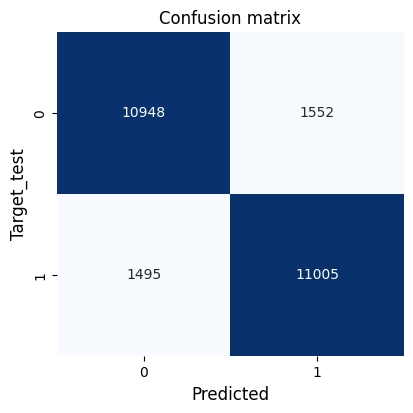

In [ ]:
confusion_matrix_map(target_test, predicted_test)

In [ ]:
'''# сохранение модели и проверка загрузки
filename = 'model_status.sav'
pickle.dump(best_model_status, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
loaded_model
'''

Теперь построим модель на основе нейросети и посмотрим, как изменится качество предсказаний.

## Нейросеть

In [7]:
features_train_nn, features_valid_nn, target_train_nn, target_valid_nn = train_test_split(
    train_data['text_clean'], train_data['positive'], test_size=0.20, random_state=RANDOM_STATE, stratify=train_data['positive'])

In [8]:
count_tf_idf = TfidfVectorizer(stop_words=list(STOP_WORDS))

tf_idf_train = count_tf_idf.fit_transform(features_train_nn)
tf_idf_valid = count_tf_idf.transform(features_valid_nn)
tf_idf_test = count_tf_idf.transform(features_test['text_clean'])

print("Размер матрицы train:", tf_idf_train.shape)
print("Размер матрицы valid:", tf_idf_valid.shape)
print("Размер матрицы test:", tf_idf_test.shape)

Размер матрицы train: (19920, 55911)
Размер матрицы valid: (4980, 55911)
Размер матрицы test: (25000, 55911)


In [9]:
selector = SelectKBest(chi2, k=10000)

tf_idf_train_slct = selector.fit_transform(tf_idf_train, target_train_nn)
tf_idf_valid_slct = selector.transform(tf_idf_valid)
tf_idf_test_slct = selector.transform(tf_idf_test)

print("Размер матрицы train:", tf_idf_train_slct.shape)
print("Размер матрицы valid:", tf_idf_valid_slct.shape)
print("Размер матрицы test:", tf_idf_test_slct.shape)

Размер матрицы train: (19920, 10000)
Размер матрицы valid: (4980, 10000)
Размер матрицы test: (25000, 10000)


Построим простую нейросеть для бинарной классификации:

In [10]:
def build_neural_network():
    model = tf.keras.Sequential([
        layers.Dense(64, input_shape=(10000, )),
        layers.Dropout(0.5),
        layers.Dense(10, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')

])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

    return model

In [11]:
model_nn = build_neural_network()

In [12]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 640,725
Trainable params: 640,725
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_nn.fit(tf_idf_train_slct.toarray(),target_train_nn,
                       epochs=4,
                       batch_size=100,
                       validation_data=(tf_idf_valid_slct.toarray(), target_valid_nn))

Epoch 1/4
200/200 [==============================] - 5s 19ms/step - loss: 0.4807 - binary_accuracy: 0.8039 - val_loss: 0.2962 - val_binary_accuracy: 0.8873
Epoch 2/4
200/200 [==============================] - 4s 18ms/step - loss: 0.2716 - binary_accuracy: 0.9080 - val_loss: 0.2614 - val_binary_accuracy: 0.8920
Epoch 3/4
200/200 [==============================] - 4s 21ms/step - loss: 0.2134 - binary_accuracy: 0.9374 - val_loss: 0.2775 - val_binary_accuracy: 0.8867
Epoch 4/4
200/200 [==============================] - 4s 19ms/step - loss: 0.1786 - binary_accuracy: 0.9471 - val_loss: 0.2915 - val_binary_accuracy: 0.8819


In [ ]:
'''
# очистка памяти
import gc
gc.collect()
'''

16219

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Построим график изменения точности и потерь от количества эпох:

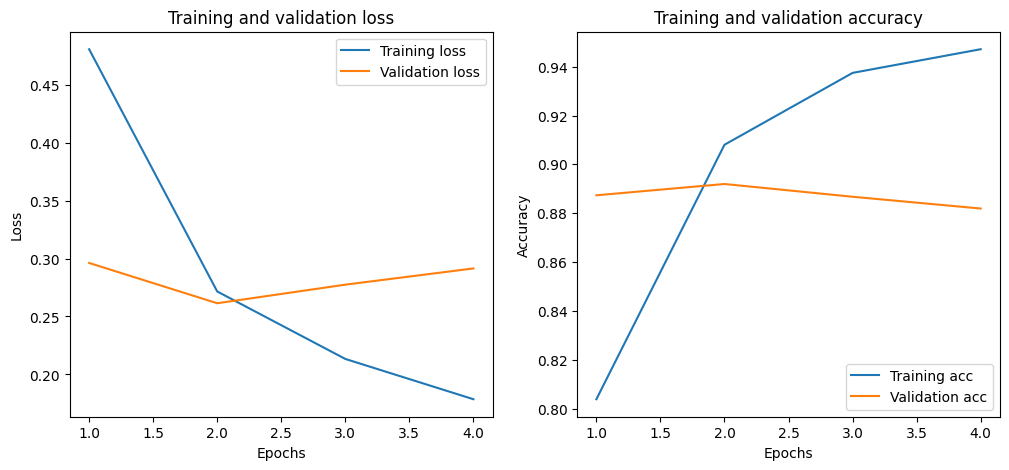

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Видим, что на валидации потери после 2 эпох начинают возрастать, а точность начинает падать. Это говорит о переобучении модели после 2 эпох. Обучим модель на 2 эпохах и посмотрим на результат:

In [ ]:
model_nn = build_neural_network()


history = model_nn.fit(tf_idf_train_slct.toarray(),target_train_nn,
                       epochs=2,
                       batch_size=100,
                       validation_data=(tf_idf_valid_slct.toarray(), target_valid_nn))

Epoch 1/2
200/200 [==============================] - 6s 25ms/step - loss: 0.5149 - binary_accuracy: 0.7787 - val_loss: 0.3115 - val_binary_accuracy: 0.8809
Epoch 2/2
200/200 [==============================] - 4s 22ms/step - loss: 0.2806 - binary_accuracy: 0.9055 - val_loss: 0.2616 - val_binary_accuracy: 0.8908


На валидации accuracy = 89,1%. Это результат сопоставимый с выбранной лучшей ML-моделью SGDClassifier. Вероятно, что более высокую точность можно достичь с помощью эмбиддингов на предобученной модели BERT, но данный процесс занимает много времени и требует более высокие вычислительные ресурсы.  

Проверим результат нейросети на тестовых данных:

In [ ]:
predictions = model_nn.predict(tf_idf_test_slct.toarray())

782/782 [==============================] - 2s 3ms/step


In [ ]:
predicted_test = []
for i in predictions:
    if i<0.5:
        predicted_test.append(0)
    else:
        predicted_test.append(1)

In [ ]:
print(classification_report(target_test, predicted_test))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88     12500
           1       0.90      0.84      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



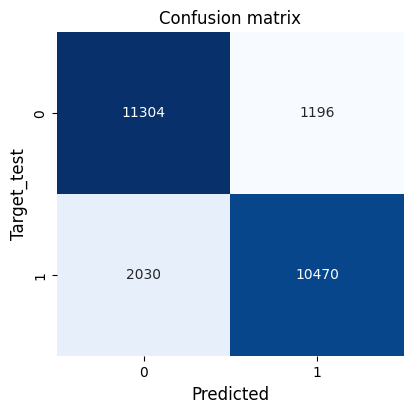

In [ ]:
confusion_matrix_map(target_test, predicted_test)

Видим, что результат даже немного хуже, чем у SGDClassifier, и предсказание классов менее равномерное. Поэтому остановимся на более простой модели SGDClassifier, которая дает достаточно хорошие результаты на предобработанном тесте.

In [ ]:
'''
model_nn.save('nn_model_status.h5', save_format='h5')
model_nn = tf.keras.models.load_model('nn_model_status.h5')
'''

# Предсказание рейтинга

## Классические ML-модели

In [13]:
features_train_rat, features_valid_rat, target_train_rat, target_valid_rat = train_test_split(
    train_data['text_clean'], train_data['rating'], test_size=0.20, random_state=RANDOM_STATE, stratify=train_data['rating'])

In [14]:
count_tf_idf = TfidfVectorizer(stop_words=list(STOP_WORDS))

tf_idf_train = count_tf_idf.fit_transform(features_train_rat)
tf_idf_valid = count_tf_idf.transform(features_valid_rat)
tf_idf_test = count_tf_idf.transform(features_test['text_clean'])

print("Размер матрицы train:", tf_idf_train.shape)
print("Размер матрицы valid:", tf_idf_valid.shape)
print("Размер матрицы test:", tf_idf_test.shape)

Размер матрицы train: (19920, 55934)
Размер матрицы valid: (4980, 55934)
Размер матрицы test: (25000, 55934)


Проверим несколько классических моделей:

In [15]:
model = LGBMClassifier(n_estimators = 300, random_state=RANDOM_STATE, class_weight='balanced')
model.fit(tf_idf_train, target_train_rat)
predicted_valid = model.predict(tf_idf_valid)

print(classification_report(target_valid_rat, predicted_valid))

              precision    recall  f1-score   support

           1       0.57      0.64      0.61      1013
           2       0.22      0.16      0.18       454
           3       0.20      0.17      0.19       483
           4       0.29      0.29      0.29       536
           7       0.29      0.26      0.27       499
           8       0.28      0.28      0.28       601
           9       0.18      0.14      0.16       451
          10       0.49      0.59      0.54       943

    accuracy                           0.38      4980
   macro avg       0.31      0.32      0.31      4980
weighted avg       0.36      0.38      0.37      4980



In [16]:
model = SGDClassifier(random_state=RANDOM_STATE, class_weight='balanced')
model.fit(tf_idf_train, target_train_rat)
predicted_valid = model.predict(tf_idf_valid)

print(classification_report(target_valid_rat, predicted_valid))

              precision    recall  f1-score   support

           1       0.56      0.72      0.63      1013
           2       0.18      0.12      0.15       454
           3       0.22      0.18      0.19       483
           4       0.29      0.30      0.30       536
           7       0.27      0.28      0.28       499
           8       0.27      0.22      0.24       601
           9       0.22      0.18      0.20       451
          10       0.53      0.59      0.56       943

    accuracy                           0.39      4980
   macro avg       0.32      0.32      0.32      4980
weighted avg       0.36      0.39      0.37      4980



In [17]:
model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=300)
model.fit(tf_idf_train, target_train_rat)
predicted_valid = model.predict(tf_idf_valid)

print(classification_report(target_valid_rat, predicted_valid))

              precision    recall  f1-score   support

           1       0.63      0.57      0.60      1013
           2       0.24      0.23      0.24       454
           3       0.24      0.25      0.24       483
           4       0.31      0.33      0.32       536
           7       0.31      0.36      0.33       499
           8       0.29      0.27      0.28       601
           9       0.21      0.24      0.22       451
          10       0.55      0.54      0.54       943

    accuracy                           0.39      4980
   macro avg       0.35      0.35      0.35      4980
weighted avg       0.40      0.39      0.39      4980



Лучшие результаты при предсказании рейтинга показала `LogisticRegression` с параметрами `{class_weight: 'balanced', max_iter: 300}`

Дообучим лучшую модель на полной обучающей выборке:

In [18]:
count_tf_idf = TfidfVectorizer(stop_words=list(STOP_WORDS))
tf_idf_train_ = count_tf_idf.fit_transform(features_train['text_clean'])
tf_idf_test_ = count_tf_idf.transform(features_test['text_clean'])

print("Размер матрицы:", tf_idf_train_.shape)
print("Размер матрицы:", tf_idf_test_.shape)

Размер матрицы: (24900, 61639)
Размер матрицы: (25000, 61639)


Проверим результаты на тестовой выборке:

In [19]:
best_model_rating = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=300)
best_model_rating.fit(tf_idf_train_, train_data['rating'])
predicted_test = best_model_rating.predict(tf_idf_test_)

print(classification_report(test_data['rating'], predicted_test))

              precision    recall  f1-score   support

           1       0.63      0.60      0.62      5022
           2       0.21      0.21      0.21      2302
           3       0.23      0.22      0.22      2541
           4       0.28      0.33      0.30      2635
           7       0.27      0.30      0.28      2307
           8       0.25      0.22      0.23      2850
           9       0.20      0.21      0.21      2344
          10       0.56      0.54      0.55      4999

    accuracy                           0.38     25000
   macro avg       0.33      0.33      0.33     25000
weighted avg       0.38      0.38      0.38     25000



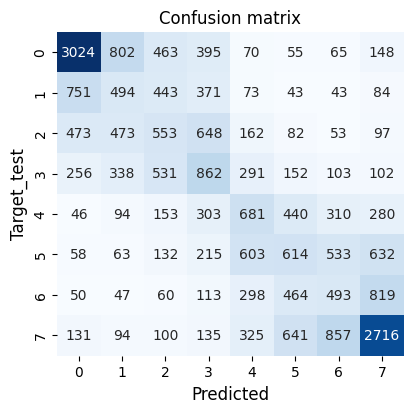

In [23]:
confusion_matrix_map(test_data['rating'], predicted_test)

Результаты именно точных ответов не очень высокие (accuracy = 38%), что объясняется сложностью точного предсказания мультиклассов по сравнению с бинарной классификацией. Однако по матрице ошибок видно достаточно неплохое попадание в соседние (близкие) классы.  

In [ ]:
'''# сохранение модели и проверка загрузки
filename = 'model_rating.sav'
pickle.dump(best_model_rating, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
loaded_model
'''

## Нейросеть

In [24]:
selector = SelectKBest(chi2, k=10000)

tf_idf_train_slct = selector.fit_transform(tf_idf_train, target_train_rat)
tf_idf_valid_slct = selector.transform(tf_idf_valid)
tf_idf_test_slct = selector.transform(tf_idf_test)

print("Размер матрицы train:", tf_idf_train_slct.shape)
print("Размер матрицы valid:", tf_idf_valid_slct.shape)
print("Размер матрицы test:", tf_idf_test_slct.shape)

Размер матрицы train: (19920, 10000)
Размер матрицы valid: (4980, 10000)
Размер матрицы test: (25000, 10000)


Построим простую нейросеть для множественной классификации:

In [25]:
def build_neural_network_rat():
    model = tf.keras.Sequential([
        layers.Dense(128, input_shape=(10000, )),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(11, activation='softmax')

])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

    return model

In [26]:
model_nn_rat = build_neural_network_rat()

In [27]:
history = model_nn_rat.fit(tf_idf_train_slct.toarray(),target_train_rat,
                          epochs=4,
                          batch_size=100,
                          validation_data=(tf_idf_valid_slct.toarray(), target_valid_rat))

Epoch 1/4
200/200 [==============================] - 7s 29ms/step - loss: 1.9728 - sparse_categorical_accuracy: 0.2918 - val_loss: 1.6043 - val_sparse_categorical_accuracy: 0.3882
Epoch 2/4
200/200 [==============================] - 6s 31ms/step - loss: 1.5356 - sparse_categorical_accuracy: 0.4200 - val_loss: 1.4624 - val_sparse_categorical_accuracy: 0.4299
Epoch 3/4
200/200 [==============================] - 5s 25ms/step - loss: 1.3735 - sparse_categorical_accuracy: 0.4699 - val_loss: 1.4580 - val_sparse_categorical_accuracy: 0.4245
Epoch 4/4
200/200 [==============================] - 5s 26ms/step - loss: 1.2766 - sparse_categorical_accuracy: 0.5051 - val_loss: 1.4877 - val_sparse_categorical_accuracy: 0.4237


In [ ]:
# gc.collect()

7433

In [29]:
predictions = model_nn_rat.predict(tf_idf_valid_slct.toarray())

pred=[]
for i in predictions:
    pred.append(np.argmax(i))



print(classification_report(target_valid_rat, pred))

156/156 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           1       0.53      0.81      0.64      1013
           2       0.00      0.00      0.00       454
           3       0.33      0.10      0.15       483
           4       0.29      0.45      0.35       536
           7       0.29      0.23      0.26       499
           8       0.31      0.32      0.31       601
           9       0.50      0.00      0.01       451
          10       0.48      0.74      0.58       943

    accuracy                           0.42      4980
   macro avg       0.34      0.33      0.29      4980
weighted avg       0.37      0.42      0.36      4980



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Не смотря на то, что на валидации общая метрика accuracy = 42% у нейросети получилась больше, чем у LogisticRegression, взвешенный показатель по классам при этом хуже (36% vs 39%): классы 2 и 9 вообще имеют нулевое f1-score. Вероятно, что более высокую точность можно достичь с помощью усложнения модели, например эмбиддингов на предобученной модели BERT, но в условиях ограниченности ресурсов остановим свой выбор на простой модели LogisticRegression.

In [ ]:
'''
model_nn_rat.save('nn_model_rating.h5', save_format='h5')
model_nn_rat = tf.keras.models.load_model('nn_model_rating.h5')
'''